In [1]:
import numpy as np, os, sys
sys.path.append("..")
import wandb

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data
from src.models import DeepCNNModel
from src.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve
from src.utils import metrics

import matplotlib as mpl 
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
# get data 
savedir = "./data"
# _=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 35,
    "patience": 3,
    }

In [5]:
WANDB= False
if WANDB:

    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="deep_cnn_synthetic_aug3",

        # track hyperparameters and run metadata
        config=config
    )

In [6]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'])


In [7]:
# set up the model, lossfn, optimizer, trainer 
model = DeepCNNModel()
lossfn = nn.BCEWithLogitsLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], weight_decay=1e-5)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'])

# Set up the learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

metrics_list = [getattr(metrics, met) for met in ['accuracy', 'auroc']]

trainer = Trainer(model, lossfn, optimizer, lr_scheduler=scheduler, metrics=metrics_list, wandb=False)
history = trainer.fit(
            loaders['train'], 
            val_loader=loaders['valid'], 
            nepochs=config['epochs'], 
        #     patience=config['epochs'],
            save_path='deep_cnn_best_model.pt'
                    )

/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate y

Model saved at epoch 1, val_loss: inf -> 0.5629
Epoch:   1/35, loss: 0.5614, accuracy: 0.5013, auroc: 0.7845, val_loss: 0.5629, val_accuracy: 0.5005, val_auroc: 0.8546


/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate y

Model saved at epoch 2, val_loss: 0.5629 -> 0.5063
Epoch:   2/35, loss: 0.4771, accuracy: 0.5025, auroc: 0.8604, val_loss: 0.5063, val_accuracy: 0.5085, val_auroc: 0.8895


/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate y

Model saved at epoch 3, val_loss: 0.5063 -> 0.4634
Epoch:   3/35, loss: 0.4316, accuracy: 0.5017, auroc: 0.8894, val_loss: 0.4634, val_accuracy: 0.5098, val_auroc: 0.9207


/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/Users/kumarh/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate y

Model saved at epoch 4, val_loss: 0.4634 -> 0.4404
Epoch:   4/35, loss: 0.3790, accuracy: 0.5025, auroc: 0.9186, val_loss: 0.4404, val_accuracy: 0.5123, val_auroc: 0.9392


KeyboardInterrupt: 

In [8]:
model.load_state_dict(torch.load("deep_cnn_best_model.pt"));

In [9]:
model = model.to("cpu")
ytest, ytestpred = [], []
for batch in loaders['test']:
    xtest, _ytest = batch
    _ytestpred = torch.sigmoid(model(xtest)).argmax(1).detach().numpy()
    ytestpred.append(_ytestpred)
    ytest.append(_ytest)
ytest = np.hstack(ytest)
ytestpred = np.hstack(ytestpred)
print((ytest == ytestpred).sum() / len(ytest))



0.49625


In [10]:
history.keys()

dict_keys(['loss', 'accuracy', 'auroc', 'val_loss', 'val_accuracy', 'val_auroc'])

In [26]:
import torchmetrics

confmat = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)
print(confmat(torch.tensor(ytestpred), torch.tensor(ytest)))
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=2)
print(accuracy(torch.tensor(ytestpred), torch.tensor(ytest)))
auroc = torchmetrics.AUROC(task="multiclass", num_classes=2)
print(auroc(torch.tensor(ytestpred), torch.tensor(ytest)))


tensor([[1985,    0],
        [2015,    0]])
tensor(0.4963)


ValueError: Expected `preds` to have one more dimension than `target` but got 1 and 1

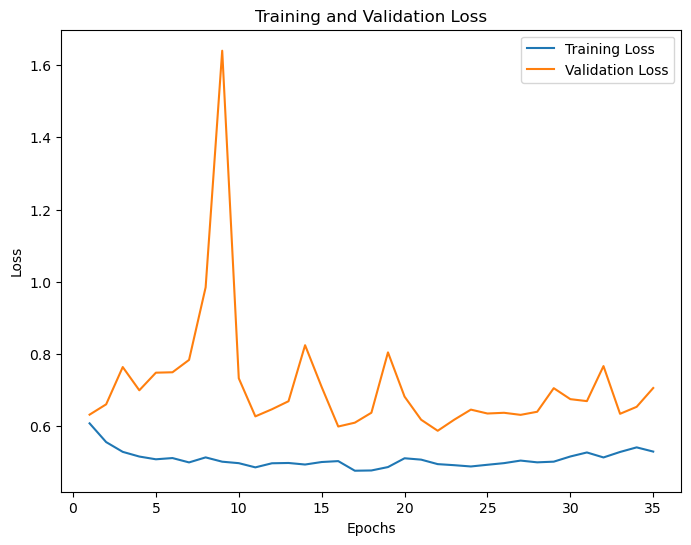

In [11]:
# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.9423


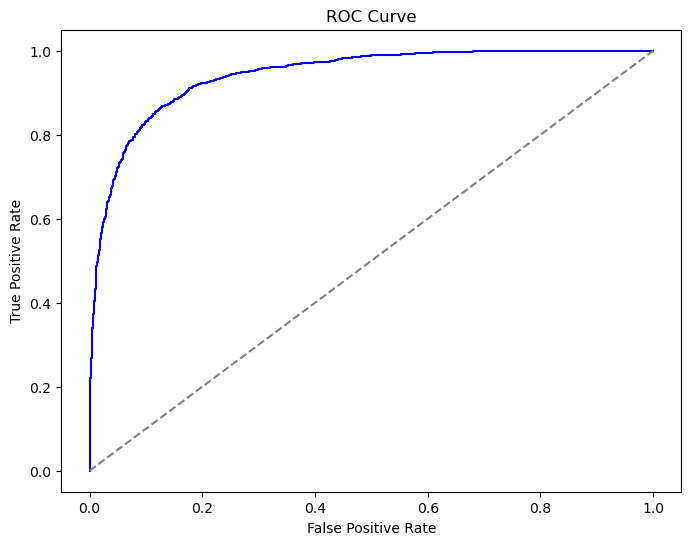

In [19]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [14]:
wandb.finish()